In [ ]:

# reading data from google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:

# library imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
import os
from math import *

# preprocessing\
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# modeling
from xgboost import XGBRegressor

# evaluation
from sklearn.metrics import mean_absolute_error

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [3]:
COMPETETION_PATH = "/content/drive/MyDrive/30-days-of-ml-competition1"
TRAIN_DATA_PATH = os.path.join("data", "train.csv")
TEST_DATA_PATH = os.path.join("data", "test.csv")


In [28]:
def read_organise_data(train=TRAIN_DATA_PATH):
    """read the data from a path and splitting to features and target

    Args:
        train (path, optional): The path of training data file to. Defaults to TRAIN_DATA_PATH.

    Returns:
        X, y: X for features and y for target
    """
    full_df = pd.read_csv(train, index_col="id")
    print(f"Shape of Dataset: {full_df.shape}")
    return full_df

df= read_organise_data()

Shape of Dataset: (300000, 25)


In [29]:
y = df.target.copy()
X = df.drop('target', axis=1).copy()

In [30]:
def create_num_cols(df):
    return df.select_dtypes(exclude="object").columns.to_list()
def create_cat_cols(df):
    return [cname for cname in df.columns if (df[cname].dtypes=="object")]

num_cnames = create_num_cols(X)
cat_cnames = create_cat_cols(X)
all_cnames = num_cnames + cat_cnames

print(f"There are {len(num_cnames)} Numerical columns")
print(f"There are {len(cat_cnames)} Categorical Columns")
print(f"In total, there are {len(all_cnames)} columns")

There are 14 Numerical columns
There are 10 Categorical Columns
In total, there are 24 columns


## EDA

<AxesSubplot:>

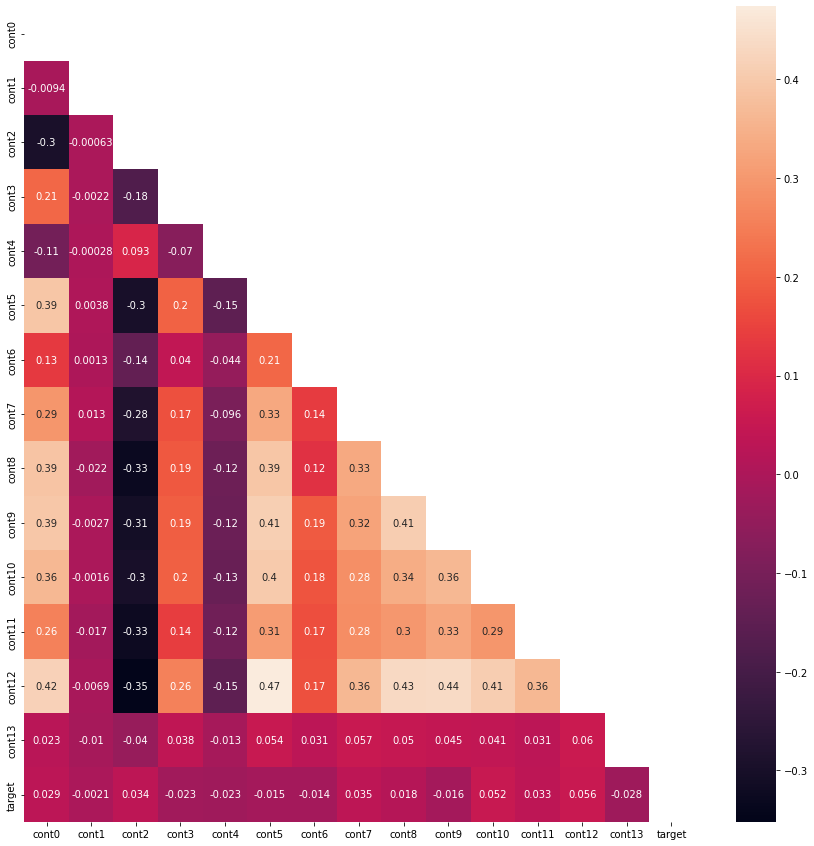

In [23]:
plt.figure(figsize=(15,15))
mask = np.triu(np.ones(df.corr().shape))
sns.heatmap(df.corr(), annot=True, mask=mask)

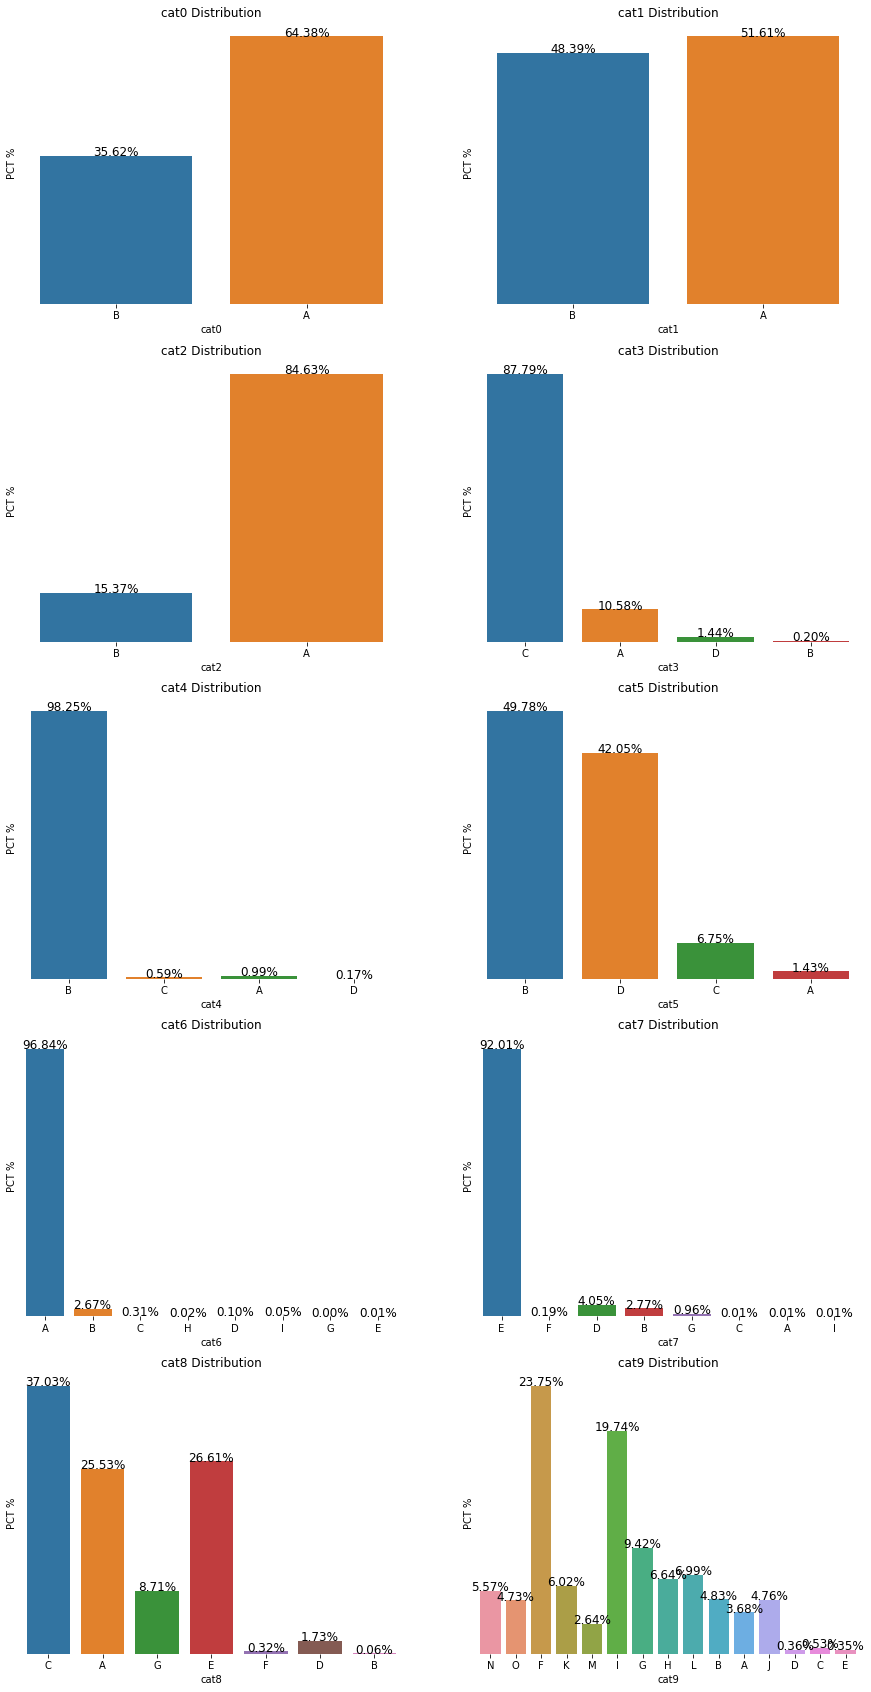

In [24]:
def count_plots_cat(df, num_rows=ceil(len(cat_cnames)/2),num_cols =2 , col_names=cat_cnames):

    fix, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15,30))
    axes = axes.ravel()
    for i in range(len(col_names)):
        col = col_names[i]
        sns.countplot(df[col], ax=axes[i]);
        axes[i].set_title(f"{col} Distribution");
        axes[i].set_yticklabels([]) # removing labels
        axes[i].set_yticks([]) # removign ticks
        axes[i].set_ylabel("PCT %")
        # removing borders 
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        # showing values in plot
        for patch in axes[i].patches:
            # get the height of the patch
            h = patch.get_height()
            axes[i].text(patch.get_x()+patch.get_width()/2,
                        h+8,'{:.2f}%'.format(h*100/len(df)),
                    fontsize = 12,ha = 'center')


count_plots_cat(X)

In [ ]:
# category columns with 1 value of more than 90% of data 
one_value_cat = []
for cname in cat_cnames:
    if df[cname].value_counts().iloc[0]/len(df) > 0.9:
        one_value_cat.append(cname)

one_value_cat

['cat4', 'cat6', 'cat7']

In [ ]:
df.describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.527335,0.460926,0.490498,0.496689,0.491654,0.510526,0.467476,0.537119,0.498456,0.474872,0.474492,0.473216,0.494561,0.508273,8.241979
std,0.230599,0.214003,0.253346,0.219199,0.240074,0.228232,0.210331,0.218140,0.239920,0.218007,0.255949,0.222022,0.247292,0.222950,0.746555
min,-0.118039,-0.069309,-0.056104,0.130676,0.255908,0.045915,-0.224689,0.203763,-0.260275,0.117896,0.048732,0.052608,-0.074208,0.151050,0.140329
25%,0.405965,0.310494,0.300604,0.329783,0.284188,0.354141,0.342873,0.355825,0.332486,0.306874,0.276017,0.308151,0.289074,0.300669,7.742071
50%,0.497053,0.427903,0.502462,0.465026,0.390470,0.488865,0.429383,0.504661,0.439151,0.434620,0.459975,0.433812,0.422887,0.472400,8.191373
75%,0.668060,0.615113,0.647512,0.664451,0.696599,0.669625,0.573383,0.703441,0.606056,0.614333,0.691579,0.642057,0.714502,0.758447,8.728634
max,1.058443,0.887253,1.034704,1.039560,1.055424,1.067649,1.111552,1.032837,1.040229,0.982922,1.055960,1.071444,0.975035,0.905992,10.411992


In [ ]:
# # dropping cont12
# dropped_cols = one_value_cat
# df.drop(dropped_cols, axis=1, inplace=True)

In [ ]:
# removing the dropped col names
# cat_cnames = list(set(cat_cnames).difference(dropped_cols))

In [31]:
# transformers
num_transformer = StandardScaler()
cat_transformer = OrdinalEncoder()

# preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cnames),
    ('cat', cat_transformer, cat_cnames)
])


In [56]:
xgb_model = XGBRegressor(n_estimators=1500, max_depth=6, learning_rate=0.05, objective='reg:squarederror', random_state=1)
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])


In [55]:

# cross validation scores
mae_scores = -1 * cross_val_score(xgb_pipeline, X, y,
                                  cv=5, scoring='neg_mean_absolute_error')

print(f"MAE Average is {mae_scores.mean()}")

"""old MAE Average is 0.5720069574587101

"""

KeyboardInterrupt: 

In [37]:
mae_scores

array([0.56882597, 0.57513658, 0.57133175, 0.57183646, 0.57290403])

In [57]:
X_test = pd.read_csv(TEST_DATA_PATH, index_col='id')

#count_plots_cat(X_test)
#X_test.drop(dropped_cols, axis=1, inplace=True)

In [58]:
xgb_pipeline.fit(X, y)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['cont0', 'cont1', 'cont2',
                                                   'cont3', 'cont4', 'cont5',
                                                   'cont6', 'cont7', 'cont8',
                                                   'cont9', 'cont10', 'cont11',
                                                   'cont12', 'cont13']),
                                                 ('cat',
                      

In [62]:
predictions = xgb_pipeline.predict(X_test)

In [60]:
OUTPUT_PATH = 'output'
def output_submission(prediction, file_name):
    """creating a kaggle submission file

    Args:
        prediction (array): an array of predictions of the test dataset
        file_name (string): a string for the name without the extension
    """
    my_submission = pd.DataFrame({'target': predictions},
                                 index=X_test.index)
    #my_submission.set_index('id')
    file_path = os.path.join(OUTPUT_PATH,file_name)
    my_submission.to_csv(f'{file_path}.csv')
    print(f'A submission file has been made at {file_path}')

In [61]:
output_submission(predictions, "submission7")

A submission file has been made at output/submission7
